In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<img width=50px  src = 'https://apps.fs.usda.gov/lcms-viewer/images/lcms-icon.png'>

# Lab 8: Export and Post-processing

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/8-Export_and_Post_Processing.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/8-Export_and_Post_Processing.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/8-Export_and_Post_Processing.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>


## 8.0: Overview and Introduction


This notebook teaches how to export data from GEE into a final platform-agnostic format


### 8.0.1: Objective

In this tutorial, you learn how to export the final thematic LCMS outputs to local CogTiffs, set custom no data values, update the names, and color map.

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Exporting assets to Google Cloud Storage
- Copying from Google Cloud Storage to a local directory
- Mosaicking and updating output color map and names
- Ensuring final output is a working CogTiff

### 8.0.2: Before you begin

#### If you are working in Workbench: Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

#### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/newFolder`
* This folder does not have to already exist. If it does not exist, it will be created

**If you are working in Qwiklabs and wish to export:** Copy the project ID from the 'Start Lab' screen into the `projectID` field in `export_path_root`.

In [47]:
workbench_url = 'https://1307eb830a12e633-dot-us-central1.notebooks.googleusercontent.com/'
pre_baked_path_root  = 'projects/rcr-gee/assets/lcms-training'
export_path_root = pre_baked_path_root

print('Done')

Done


#### Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing many data science packages such as pandas. 

In [109]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml

import os,secrets,glob
from PIL import Image
import matplotlib.pyplot as plt


ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1235


# Set up GDAL
try:
    import lcms_scripts.raster_processing_lib as rpl
except Exception as e:
    if getImagesLib.IS_WORKBENCH:
        print('GDAL is not installed. Will try to install')
        !sudo apt-get -y install libgdal-dev
        !gdal-config --version
        !pip install pygdal==3.2.2.10
        import lcms_scripts.raster_processing_lib as rpl
    else:
        print('GDAL is not installed and you are not using Workbench.')
    
print('Done')

Done


#### Set up your work environment

Create a folder in your export path where you will export the composites. In addition, create a blank image collection where your composites will live.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [110]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_assembledLCMSOutputs_collection = f'{export_path_root}/lcms-training_module-6_assembledLCMSOutputs'

token = secrets.token_hex(8)
export_bucket = f'gs://lcms-outputs-temp2'
final_output_bucket =  f'gs://lcms-outputs-final2'
!gsutil mb {export_bucket}
!gsutil mb {final_output_bucket}

local_processing_folder = '/tmp/lcms-training/local_processing'


print('Done')

Creating gs://lcms-outputs-temp2/...
ServiceException: 409 A Cloud Storage bucket named 'lcms-outputs-temp2' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Creating gs://lcms-outputs-final2/...
Done


In [50]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1235
Map.proxy_url = workbench_url

print('Done')

Done


## 8.1: Bring in Assembled LCMS Outputs and visualize

In [51]:
Map.clearMap()
# Bring in assembled LCMS asset
lcms = ee.ImageCollection(export_assembledLCMSOutputs_collection)

# Add the assembled outputs to the map and take a look
Map.addLayer(lcms,{},'Assembled LCMS')

Map.turnOnInspector()
Map.view()


Adding layer: Assembled LCMS
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://1307eb830a12e633-dot-us-central1.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


## 8.2: Export Assembled LCMS Outputs to Google Cloud Storage

In [52]:
Map.clearMap()

# Pull the projection info from the assembled asset
projection = lcms.first().projection().getInfo()
if 'crs' in projection.keys():
    crs = projection['crs']
else:
    crs = projection['wkt']
transform = projection['transform']
scale=None


# Get studyArea 
study_area = lcms.first().geometry().bounds(500,crs)

# Find the years
years = [int(float(yr)) for yr in lcms.aggregate_histogram('year').keys().getInfo()]

# Find the products
products = lcms.first().bandNames().slice(0,3).getInfo()

# Set null value
nodata_value = 0

# Get the study area name
study_area_name = lcms.first().get('study_area').getInfo()

# Set version number
version = 'vTraining2022-8'

# Iterate across each product and year and export to cloud storage
for product in products:
    lcms_class = lcms.select([product])
    
    for year in years:
        lcms_class_yr = lcms_class.filter(ee.Filter.calendarRange(year,year,'year')).first()
        
        output_name = f'LCMS_{study_area_name}_{version}_{product}_Annual_{year}'
        
        # getImagesLib.exportToCloudStorageWrapper(lcms_class_yr,output_name,os.path.basename(export_bucket),study_area,scale,crs,transform,outputNoData = nodata_value)


In [26]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the bucket of all images
# !gsutil rm {export_bucket}*.tif

print('done')

0 tasks ready 2023-09-19 16:05:30
0 tasks running 2023-09-19 16:05:30
Running names:


done


## 8.3: Copy to local folder
* Look at what is in the bucket
* Copy to local folder for post-processing

In [6]:
# First open this link to view the outputs
print(f'https://console.cloud.google.com/storage/browser/{os.path.basename(export_bucket)}')

https://console.cloud.google.com/storage/browser/lcms-outputs-temp2


In [64]:
# Copy to local folder and make sure it worked
local_raw_exports_folder = os.path.join(local_processing_folder,'raw_exports')
rpl.check_dir(local_raw_exports_folder)
!gsutil -m cp {export_bucket}/*.tif {local_raw_exports_folder}

print(os.listdir(local_raw_exports_folder))

Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1985.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1986.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1987.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1988.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1989.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1995.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2000.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1990.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1996.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1997.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1992.tif...
Copying gs://lcms-outputs-temp2/LCMS_PRUSVI_vTraining2

## 8.4 Create VRTs

* Sometimes if the raster is very large, GEE will break an individual image into tiled outputs
* We will need to ensure those get mosaicked back together 
* We will look for sets of images with the same name
* Note that for the default test study area of Puerto Rico and the US Virgin Islands, the outputs are not broken into tiles

In [77]:
# Find sets of images
local_vrt_folder = os.path.join(local_processing_folder,'VRTs')
rpl.check_dir(local_vrt_folder)
for product in products:
    for year in years:
        # print(product,year)
        tiles = glob.glob(os.path.join(local_raw_exports_folder,f'LCMS*{product}*_Annual_{year}.tif'))
        bn = rpl.base(tiles[0])
        out_vrt = bn.split('{}_Annual_{}'.format(product,year))[0]+'{}_Annual_{}.vrt'.format(product,year)
        
        
        vrt_image = os.path.join(local_vrt_folder,out_vrt)
        if not os.path.exists(vrt_image):
            rpl.buildVRT(tiles,vrt_image)
        else:
            print('Already created:',out_vrt)
print(os.listdir(local_vrt_folder))

Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1985.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1986.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1987.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1988.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1989.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1990.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1991.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1992.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1993.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1994.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1995.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1996.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1997.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Change_Annual_1998.vrt
Already created: LCMS_PRUSVI_vTraining2022-8_Cha

## 8.4 Set Colors

* All thematic LCMS outputs have a default color map and names applied
* We will pull the values in from GEE to then be set in the local tifs


In [95]:
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2022-8").filter('study_area=="PRUSVI"').first().toDictionary().getInfo()

color_names_dict = {}

for product in products:
    colors = lcms_viz_dict[f'{product}_class_palette']
    colors = [f'#{c}' for c in colors]
    colors.insert(0,'#000000')
    
    names = lcms_viz_dict[f'{product}_class_names']
    names.insert(0,'')
    
    ct = rpl.get_ct(colors)
    
    color_names_dict[product] = {'ct':ct,'names':names}


In [98]:
vrts = glob.glob(os.path.join(local_vrt_folder,'*.vrt'))
version = 'vTraining2022-8'
for vrt in vrts:
    product = rpl.base(vrt)
    product = product.split(version+'_')[1].split('_Annual_')[0]
   
    rpl.update_color_table_or_names(vrt,color_table =color_names_dict[product]['ct'],names = color_names_dict[product]['names'])
        

/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.vrt
('Updating color table for:', '/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.vrt')
('Updating names for:', '/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.vrt')
/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2004.vrt
('Updating color table for:', '/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2004.vrt')
('Updating names for:', '/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2004.vrt')
/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Cover_Annual_2003.vrt
('Updating color table for:', '/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Cover_Annual_2003.vrt')
('Updating names for:', '/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Lan

## 8.4 Final Post Processing

* We will now:
    * Set no data
    * Update stats
    * Ensure the projection is set properly
    * Compute pyramids
    * Recreate COG after breaking it
    * Validate it is a valid COG
     


In [99]:
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
vrts = glob.glob(os.path.join(local_vrt_folder,'*.vrt'))

for vrt in vrts:
    rpl.update_cog(vrt,crs,no_data_value = 0, update_stats = True, stat_stretch_type = None,pyramid_reducer = 'MODE',bigtiff='YES')


Updating crs and no data and preserving COG layout for:  /tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.vrt
out_image_name /tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.tif
('Min:', 1.0)
('Max:', 7.0)
('Mean:', 3.21659654186694)
('Std:', 1.2288699853152105)
/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.tif is a valid cloud optimized GeoTIFF

The size of all IFD headers is 28914 bytes
/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_1991.tif is a valid COGTiff:  True
Updating crs and no data and preserving COG layout for:  /tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2004.vrt
out_image_name /tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2004.tif
('Min:', 1.0)
('Max:', 5.0)
('Mean:', 1.0001531524080003)
('Std:', 0.02474462159675301)
/tmp/lcms-training

## 8.5 Move and View final LCMS outputs

* Move outputs back to Google Cloud Storage so we can move them wherever we will need the outputs (local, GEE, AWS, etc...)

* We will then view the final cogTiffs in:
    * PyPlot
    * Bring them back in GEE
     


In [116]:
# Copy cogTif and xml (color table) to GCS
!gsutil -m cp {local_vrt_folder}/*.tif {final_output_bucket}
!gsutil -m cp {local_vrt_folder}/*.tif.aux.xml {final_output_bucket}


Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1985.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1986.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1987.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1988.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1991.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1990.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Change_Annual_1996.tif [Content-Type=image/tiff]...
Copying file:///tmp/lcms-training/local_processi

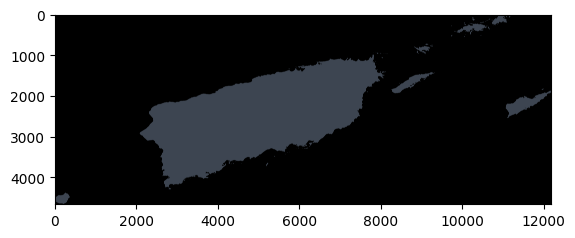

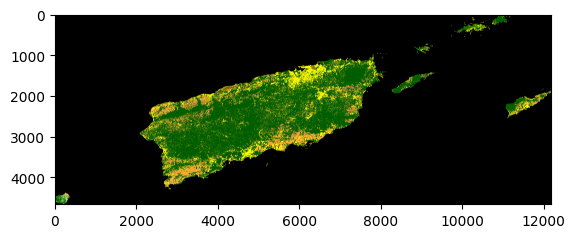

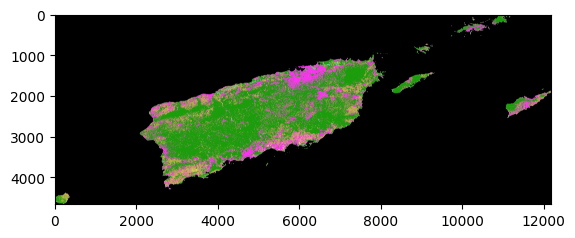

In [112]:
# Now, let's view them as an image
year = 2017
for product in products:
    cogs = glob.glob(os.path.join(local_vrt_folder,f'*{product}*{year}*.tif'))
    img1 = Image.open(cogs[0], 'r')
    plt.imshow(img1)

    plt.show()

In [124]:
# Next, we'll bring the same images into GEE
Map.clearMap()
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2022-8").filter('study_area=="PRUSVI"').first().toDictionary().getInfo()

year = 2017
for product in products:
    cog = glob.glob(os.path.join(local_vrt_folder,f'*{product}*{year}*.tif'))[0]
    print(cogs)
    uri = os.path.join(final_output_bucket,os.path.basename(cog))
    print(uri)
    img = ee.Image.loadGeoTIFF(uri).rename([product]).set(lcms_viz_dict)
    Map.addLayer(img,{'autoViz':True},f'LCMS {product} {year}')

Map.turnOnInspector()
Map.view()

['/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_2017.tif']
gs://lcms-outputs-final2/LCMS_PRUSVI_vTraining2022-8_Change_Annual_2017.tif
Adding layer: LCMS Change 2017
['/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_2017.tif']
gs://lcms-outputs-final2/LCMS_PRUSVI_vTraining2022-8_Land_Cover_Annual_2017.tif
Adding layer: LCMS Land_Cover 2017
['/tmp/lcms-training/local_processing/VRTs/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_2017.tif']
gs://lcms-outputs-final2/LCMS_PRUSVI_vTraining2022-8_Land_Use_Annual_2017.tif
Adding layer: LCMS Land_Use 2017
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://1307eb830a12e633-dot-us-central1.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


## Lab 8 challenge:
TBD

In [ ]:
# insert challenge code here

## Done with Module 8